In [45]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas_gbq
import os
pd.options.display.max_columns = 100
pd.options.display.max_rows = 300

import pandas as pd
from google.oauth2 import service_account

from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy

from tqdm.auto import tqdm

#plt.style.use('ggplot')

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px


import seaborn as sns
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

- load a date

In [22]:
df.to_csv('data_roling.csv')

In [23]:
df = pd.read_csv('data_roling.csv')

In [24]:
df.head()

,Unnamed: 0,id,first_date,last_date
0,0,1654078162854-3686194101666947115,2022-06-01,2022-06-02
1,1,1654079409666-5183708671023699730,2022-06-01,2022-06-04
2,2,1654076049818-6925503782193218290,2022-06-01,2022-07-21
3,3,1654076918435-1252637173574371983,2022-06-01,2022-06-03
4,4,1654078080113-8670326837793680067,2022-06-01,2022-06-26


In [26]:
df = df.drop('Unnamed: 0', axis=1)

In [27]:
df.head()

,id,first_date,last_date
0,1654078162854-3686194101666947115,2022-06-01,2022-06-02
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04
2,1654076049818-6925503782193218290,2022-06-01,2022-07-21
3,1654076918435-1252637173574371983,2022-06-01,2022-06-03
4,1654078080113-8670326837793680067,2022-06-01,2022-06-26


- rolling retention

In [29]:
# convert to datetime
df['first_date'] = pd.to_datetime(df['first_date'])
df['last_date'] = pd.to_datetime(df['last_date'])


In [30]:
# the diffrence in days between first and last visits
df['days_visited'] = df[['last_date','first_date']].apply(lambda x: x['last_date']-x['first_date'], axis=1).dt.days


In [31]:
# add empty days
df['days_visited_range'] = df['days_visited'].apply(lambda x:range(0,x))

In [32]:
# extract days from list
df = df.explode('days_visited_range')

In [33]:
# replace empty days
df['days_visited_range'] = df['days_visited_range'].fillna(0)

In [34]:
df.head()

,id,first_date,last_date,days_visited,days_visited_range
0,1654078162854-3686194101666947115,2022-06-01,2022-06-02,1,0
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04,3,0
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04,3,1
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04,3,2
2,1654076049818-6925503782193218290,2022-06-01,2022-07-21,50,0


In [35]:
df['users'] = 1

In [36]:
df.head()

,id,first_date,last_date,days_visited,days_visited_range,users
0,1654078162854-3686194101666947115,2022-06-01,2022-06-02,1,0,1
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04,3,0,1
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04,3,1,1
1,1654079409666-5183708671023699730,2022-06-01,2022-06-04,3,2,1
2,1654076049818-6925503782193218290,2022-06-01,2022-07-21,50,0,1


In [37]:
# pivot table
roll_ret_df = df.pivot_table(index = 'first_date', values = 'users', columns = 'days_visited_range', aggfunc=np.sum).fillna(0).T


In [39]:
roll_ret_df.head()

first_date,2022-06-01,2022-06-02,2022-06-03,2022-06-04,2022-06-05
days_visited_range,,,,,
0,4364.0,3996.0,5073.0,6446.0,6139.0
1,2716.0,2517.0,3094.0,3885.0,3651.0
2,2380.0,2192.0,2656.0,3318.0,3172.0
3,2188.0,1988.0,2391.0,2997.0,2894.0
4,2026.0,1831.0,2189.0,2793.0,2667.0


In [40]:
# calculated rolling retention
roll_ret_df_norm = roll_ret_df.apply(lambda x: 100*x/roll_ret_df.loc[0], axis = 1).applymap(lambda x: x if x!=0 else None)


In [42]:
roll_ret_df_norm = roll_ret_df_norm.fillna(0)

In [43]:
roll_ret_df_norm

first_date,2022-06-01,2022-06-02,2022-06-03,2022-06-04,2022-06-05
days_visited_range,,,,,
0,100.000000,100.000000,100.000000,100.000000,100.000000
1,62.236480,62.987988,60.989553,60.269935,59.472227
2,54.537122,54.854855,52.355608,51.473782,51.669653
3,50.137489,49.749750,47.131875,46.493950,47.141228
4,46.425298,45.820821,43.150010,43.329196,43.443558
5,42.804766,42.817818,40.311453,40.831523,40.869849
6,40.238313,40.390390,38.340233,38.194229,38.328718
7,37.992667,38.638639,36.191603,36.022339,35.983059
8,36.021998,36.661662,34.496353,33.245424,33.898029


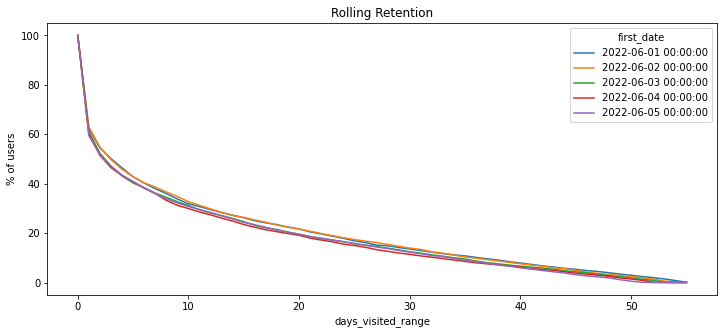

In [74]:
# visualization
roll_ret_df_norm.plot()
plt.ylabel('% of users')
plt.title('Rolling Retention')

plt.rcParams["figure.figsize"] = (12,4)

- LT

In [75]:
# calculated of the area under the curve for each cohort
LT = []
x = np.arange(len(roll_ret_df_norm))

for column in roll_ret_df_norm.columns:
    
    y = roll_ret_df_norm['{}'.format(column)].fillna(0)
    
    
    lt = np.trapz(y,x, dx=1/4)/100*7
    LT.append(lt)  

LT

[75.21310724106324,
 75.23423423423422,
 69.86960378474275,
 67.30034129692832,
 68.47605473204106]

71.2186682578019

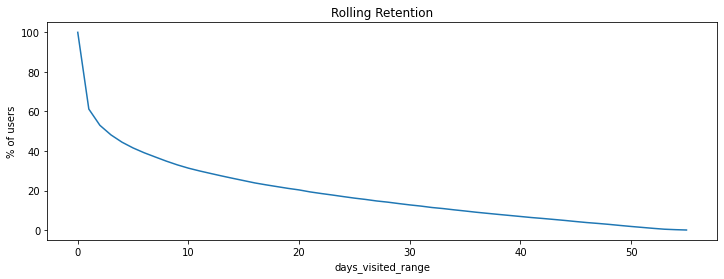

In [76]:
# calculated of the area under the curve for all cohort
roll_ret_df_norm['mean'] = roll_ret_df_norm.mean(axis=1)
roll_ret_df_norm
roll_ret_df_norm['mean'].plot()
plt.ylabel('% of users')
plt.title('Rolling Retention')
x = np.arange(len(roll_ret_df_norm))
y = roll_ret_df_norm['mean']
    
lt = np.trapz(y,x, dx=1/4)/100*7
lt